In [1]:
import torch
print(torch.cuda.is_available())

True


In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os

record_path = r'C:\Vinh\CSSALT\CSSALT-waveform-classify-model\mit-bih-malignant-ventricular-ectopy-database-1.0.0\mit-bih-malignant-ventricular-ectopy-database-1.0.0'
record_files = [f.split('.')[0] for f in os.listdir(record_path) if f.endswith('.dat')]
segment_length = 4 
fs = None

for record_name in record_files:
    record = wfdb.rdrecord(f'{record_path}\\{record_name}')
    if fs is None:
        fs = record.fs

    total_images = 120  

    for i in range(total_images):
        start = i * fs  
        end = start + segment_length * fs 

        if end > record.p_signal.shape[0]:
            break

        ecg_segment = record.p_signal[start:end, 0]

        plt.figure(figsize=(12, 4))
        plt.plot(np.arange(len(ecg_segment)) / fs, ecg_segment)
        plt.axis('off')
        plt.tight_layout()

        plt.savefig(f'C:\\Vinh\\CSSALT\\CSSALT-waveform-classify-model\\VFib\\{record_name}_{i+1}.png', bbox_inches='tight', pad_inches=0)
        plt.close()


In [26]:
import pandas as pd
import wfdb
import numpy as np
import os

base_path = r"C:\Vinh\CSSALT\CSSALT-waveform-classify-model\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
metadata_path = os.path.join(base_path, "ptbxl_database.csv")  

df = pd.read_csv(metadata_path)

ecg_segments = []

threshold = 5

for idx, row in df.iterrows():
    scp_codes = eval(row["scp_codes"])  

    if "NORM" not in scp_codes or abs(scp_codes["NORM"] - 100) > threshold:
        continue
    hr_path = os.path.join(base_path, row["filename_hr"])  

    record = wfdb.rdrecord(hr_path)

    ecg_signal = record.p_signal[:, 0]

    segment_size = 2000
    num_segments = len(ecg_signal) // segment_size  

    for i in range(num_segments):
        segment = ecg_signal[i * segment_size : (i + 1) * segment_size]
        ecg_segments.append(segment)

    if len(ecg_segments) >= 200:
        break

ecg_segments = np.array(ecg_segments)
ecg_segments = ecg_segments * 1000

lr_ecg_segments = []
for ecg_segment in ecg_segments:
    lr_ecg_segment = []
    for i in range(len(ecg_segment)):
        if (i % 5 == 0):
            lr_ecg_segment.append(ecg_segment[i])
        elif (i % 5 == 2):
            lr_ecg_segment.append((ecg_segment[i] + ecg_segment[i + 1])/2)
    lr_ecg_segments.append(lr_ecg_segment)

lr_ecg_segments = np.array(lr_ecg_segments)

np.save(os.path.join(base_path, "lr_ecg_segments.npy"), lr_ecg_segments)

print(f"Extracted {len(lr_ecg_segments)} ECG segments of 800 samples each.")


Extracted 200 ECG segments of 800 samples each.


In [27]:
lr_ecg_segments

array([[-1.150e+02, -1.150e+02, -1.150e+02, ..., -4.300e+01,  0.000e+00,
        -3.900e+01],
       [-5.000e+01, -5.550e+01,  0.000e+00, ...,  4.600e+01,  1.600e+02,
         1.290e+02],
       [-3.500e+01, -3.500e+01, -3.500e+01, ..., -2.450e+01,  0.000e+00,
        -3.200e+01],
       ...,
       [-8.000e+01, -7.350e+01, -8.500e+01, ..., -4.000e+01,  1.000e+01,
        -5.000e-01],
       [-6.500e+01, -6.500e+01, -6.500e+01, ..., -1.500e+01, -3.000e+01,
        -5.000e+01],
       [-7.000e+01, -7.100e+01, -6.000e+01, ...,  5.580e+02,  8.800e+02,
         9.845e+02]])

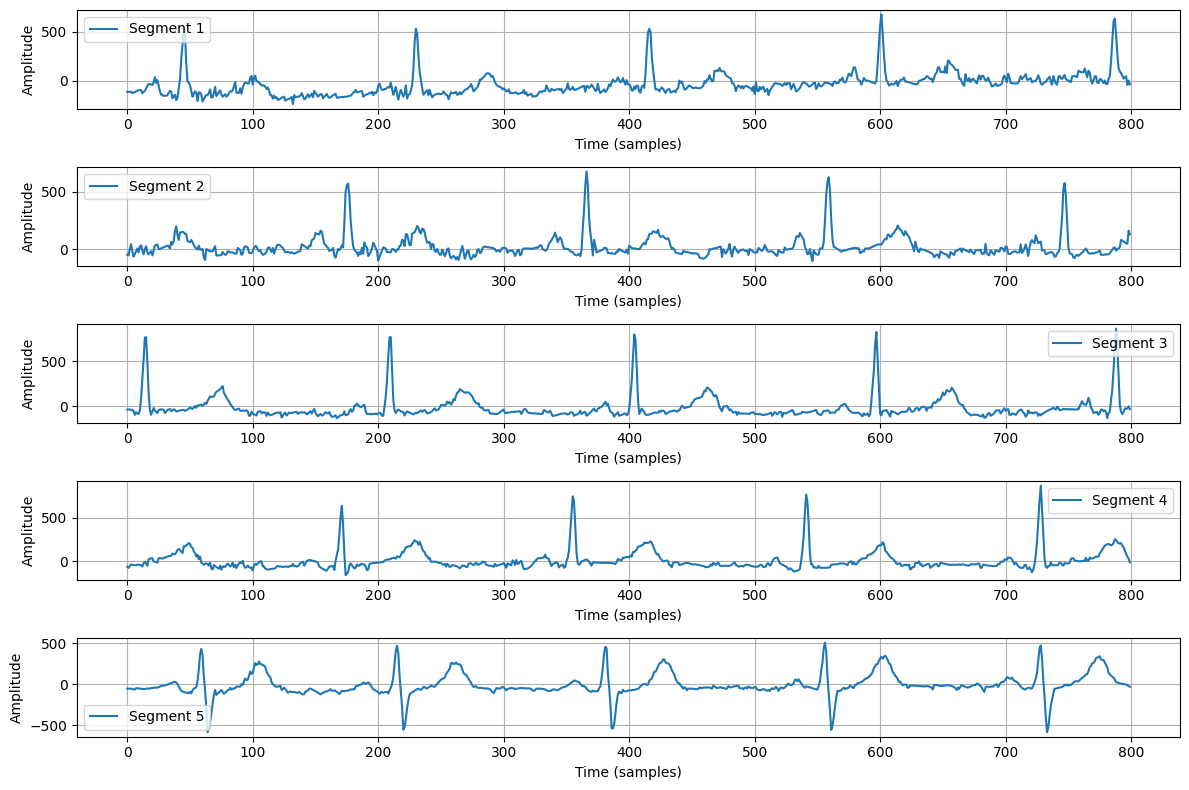

In [28]:
import matplotlib.pyplot as plt

num_segments = min(5, len(lr_ecg_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(lr_ecg_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

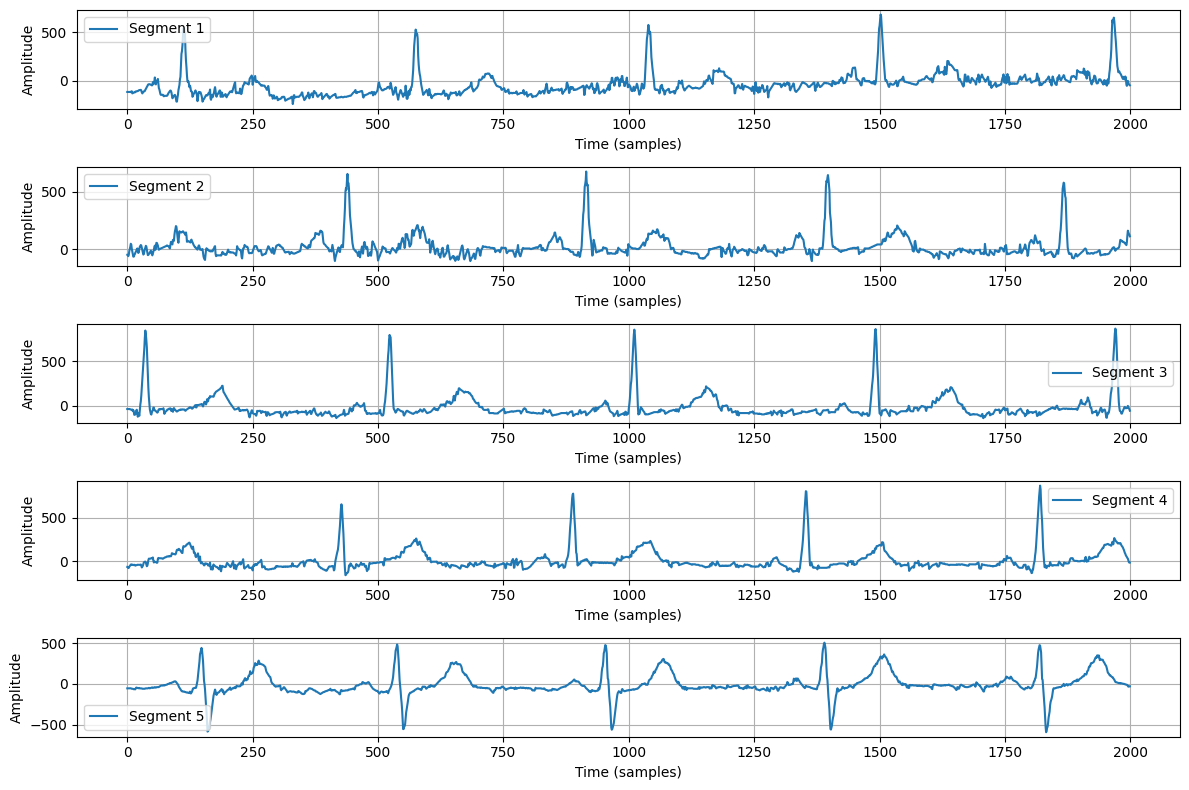

In [29]:
import matplotlib.pyplot as plt

num_segments = min(5, len(ecg_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(ecg_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

In [35]:
base_path = r"C:\Vinh\CSSALT\CSSALT-waveform-classify-model\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
metadata_path = os.path.join(base_path, "augmented_ecg_data.csv")  
vfib_df = pd.read_csv(metadata_path)
vfib_segments = vfib_df.to_numpy()

def replace_outliers(signal, threshold=1000):
    for i in range(len(signal)):
        if abs(signal[i]) > threshold:
            prev_value = signal[i - 1] if i > 0 else 0 
            next_value = signal[i + 1] if i < len(signal) - 1 else 0  
            signal[i] = (prev_value + next_value) / 2
    return signal

for vfib_segment in vfib_segments:
    replace_outliers(vfib_segment)

vfib_segments

array([[ -60.36217304,  -96.27556427, -146.20632119, ...,  206.71049259,
          88.73664457,   13.55015215],
       [-221.32796781, -310.58350143, -407.31931778, ...,  110.8464808 ,
         102.80373694,    9.5157739 ],
       [-100.60362173, -174.28315877, -273.20960215, ...,  246.77623581,
         108.5297924 ,  -86.86437399],
       ...,
       [ -60.36217304, -138.94171047, -142.64069599, ...,   72.00844562,
          94.18767369,  -25.69553224],
       [-100.60362173, -197.25795603, -299.53530174, ...,   31.76699693,
          93.18470634,   -7.59077226],
       [-181.08651911, -261.91104897, -227.59090155, ...,   51.88772127,
         115.52526942,   -3.12889643]])

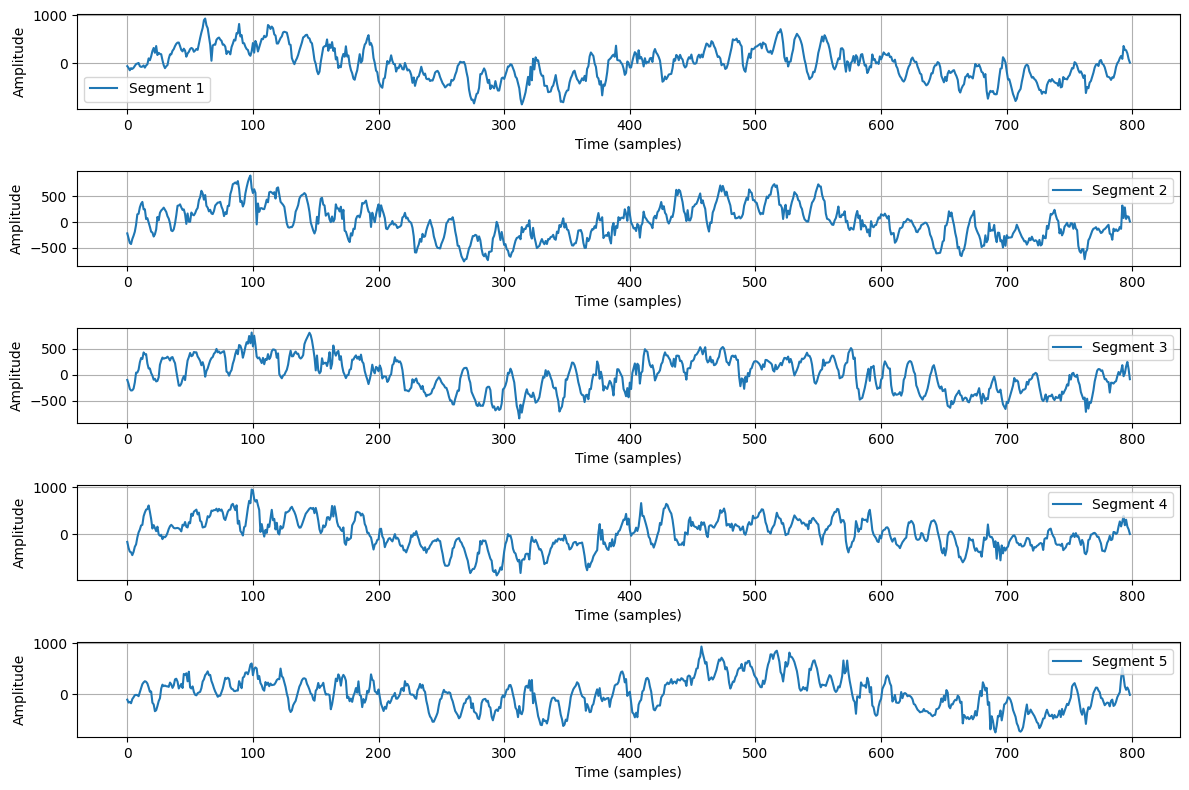

In [36]:
num_segments = min(5, len(vfib_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(vfib_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()